# e-Stat API機能で取得した人口移動データをprophetで学習し、2020年の人口移動を予測する

## 人口移動データ取得

In [1]:
import os
import io
import requests
import pandas as pd
from fbprophet import Prophet

%matplotlib inline
pd.plotting.register_matplotlib_converters()
app_id = os.getenv("E_STAT_API_APP_ID")

In [2]:
def get_stats_name_list():
    url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsList"
    params = {"appId": app_id, "statsNameList": "Y"}
    response = requests.get(url, params=params)
    csv_text = response.text[response.text.find('"TABLE_INF",') :]
    df = pd.read_csv(io.StringIO(csv_text), dtype="object")
    return df

In [3]:
df_stats_name = get_stats_name_list().pipe(
    lambda df: df[df.STAT_NAME.str.contains("人口移動")]
)

In [4]:
df_stats_name

,TABLE_INF,STAT_CODE,STAT_NAME,GOV_ORG_CODE,GOV_ORG_NAME
17,00200523,00200523,住民基本台帳人口移動報告,00200,総務省


In [5]:
stats_code = df_stats_name.TABLE_INF

In [6]:
def get_stats_list(stats_code):
    url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsList"
    params = {"appId": app_id, "statsCode": stats_code}
    response = requests.get(url, params=params)
    csv_text = response.text[response.text.find('"TABLE_INF",') :]
    df = pd.read_csv(io.StringIO(csv_text), dtype="object")
    return df

In [7]:
df_stats_list = get_stats_list(stats_code).pipe(
    lambda df: df[
        (df.CYCLE == "月次")
        & (df.TITLE.str.contains("全国"))
        & (df.TITLE.str.contains("2010年1月"))
        & (df.TITLE.str.contains("転入者数"))
    ]
)

In [8]:
df_stats_list[["TABLE_INF", "TITLE"]]

,TABLE_INF,TITLE
14,0003079521,2010年1月～ 年齢（５歳階級），男女別他都道府県からの転入者数（日本人移動者） 全国，都道府県


In [9]:
stats_data_id = df_stats_list.iloc[0].TABLE_INF

In [10]:
def get_meta_info(stats_data_id):
    url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleMetaInfo"
    params = {"appId": app_id, "statsDataId": stats_data_id}
    response = requests.get(url, params=params)
    csv_text = response.text[response.text.find('"CLASS_OBJ_ID",') :]
    df = pd.read_csv(io.StringIO(csv_text), dtype="object")
    return df

In [11]:
df_meta_info = get_meta_info(stats_data_id).dropna(axis=1).drop_duplicates('CLASS_OBJ_ID')

In [12]:
df_meta_info

,CLASS_OBJ_ID,CLASS_OBJ_NAME,CLASS_CODE,CLASS_NAME
0,tab,表章項目,06,他都道府県からの転入者数
1,cat01,性別,0,総数
4,cat02,年齢（５歳階級）,000,総数
24,area,全国・都道府県,00000,全国
72,time,時間軸（月次）,2018001212,2018年12月


In [13]:
def get_stats_data(stats_data_id, cat01, cat02, area):
    url = "http://api.e-stat.go.jp/rest/3.0/app/getSimpleStatsData"
    params = {
        "appId": app_id,
        "statsDataId": stats_data_id,
        "cdArea": area,
        "cdCat01": cat01,
        "cdCat02": cat02,
    }
    response = requests.get(url, params=params)
    csv_text = response.text[response.text.find('"tab_code",') :]
    df = pd.read_csv(io.StringIO(csv_text), dtype="object")
    return df

In [14]:
df_stas_data = get_stats_data(
    stats_data_id,
    **df_meta_info.groupby("CLASS_OBJ_ID")
    .first()
    .CLASS_CODE[["area", "cat01", "cat02"]]
    .to_dict()
)

In [15]:
def to_prophet_format(df):
    return df.pipe(
        lambda df: df.assign(ds=pd.to_datetime(df["時間軸（月次）"], format="%Y年%m月"))
    ).pipe(
        lambda df: df[["ds", "value"]]
        .astype({"value": int})
        .rename(columns={"value": "y"})
        .sort_values("ds")
    )

In [16]:
df_prophet = df_stas_data.pipe(to_prophet_format)

In [17]:
df_prophet.head()

,ds,y
107,2010-01-01,126018
106,2010-02-01,137843
105,2010-03-01,478514
104,2010-04-01,398795
103,2010-05-01,150085


In [18]:
df_prophet.tail()

,ds,y
4,2018-08-01,158332
3,2018-09-01,129291
2,2018-10-01,163296
1,2018-11-01,124295
0,2018-12-01,127839


## Prophetで学習、予測

In [19]:
prophet_model = Prophet().fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=24, freq='MS')
forecast = prophet_model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### プロット

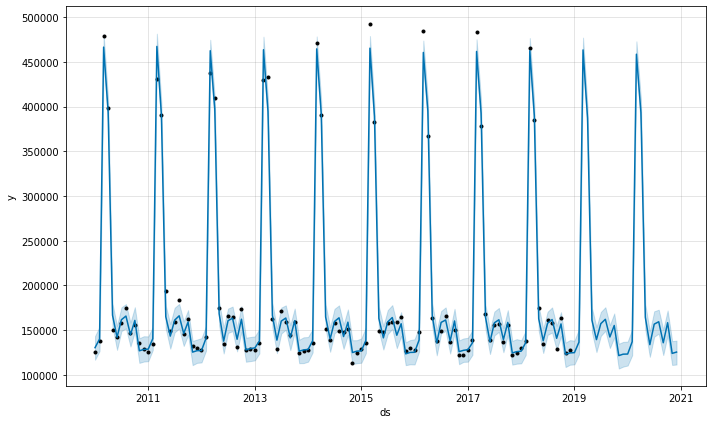

In [20]:
prophet_model.plot(forecast);

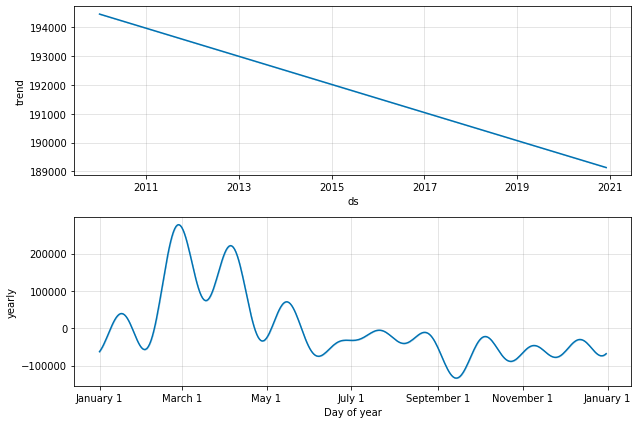

In [21]:
prophet_model.plot_components(forecast);

### 2020年の予測結果

In [22]:
forecast.set_index("ds")["2020-01-01":].yhat.apply(int).reset_index().pipe(
    lambda df: df.assign(ds=df.ds.dt.strftime("%Y年%m月"))
).set_index("ds")

,yhat
ds,
2020年01月,123240
2020年02月,137012
2020年03月,458678
2020年04月,393502
2020年05月,164402
2020年06月,133720
2020年07月,156698
2020年08月,159363
2020年09月,135871


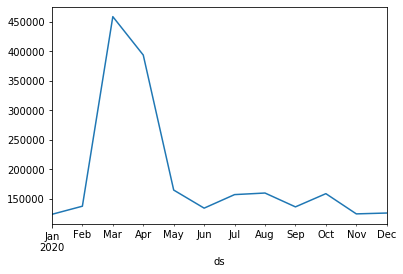

In [23]:
forecast.set_index('ds')['2020-01-01':].yhat.plot();